primero se lleva a cabo la limpieza del todas las variables preexistentes que se tuvieran asi como de la consola

In [1]:
try:
    from IPython import get_ipython
    get_ipython().run_line_magic('clear')
    get_ipython().run_line_magic('reset -f')
except:
     pass

In [32]:
os.chdir("C:\\Users\\luisd\Documents\\GitHub\\image_kmeans_processing")

Se cargan las librerias con las que funciona el script

In [11]:
import cv2 as cv # libreria para el procesamiento de imagenes
import numpy as np # no se que haga pero funciona x
import glob # liberia para leer archivos de las carpetas
import os # libreria para establecer y moverse del directorio de trabajo
import pandas as pd # esta libreria es para generar el data frame del resultado final
import matplotlib.pyplot as plt # esta libreria es para plotear dentro de la consola en python
import matplotlib.image
from openpyxl import load_workbook
from openpyxl.styles import PatternFill
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw # esta libreria hace el recorte de la parte de enmedio

la variable "n_K" es un int que almacena el numero de clusters que se utilizaran para realizar la segmentacion de la imagen

In [12]:
n_K = input('numero de clusters para la segmentacion de imagen? (max:5):')
n_K = int(n_K)

organizacion de carpetas de entrada y de salida

In [13]:
OutputROI = "ROI_Cropped"
OutputROISample = "ROI_Reconstruction"

In [42]:
Inputpath = "C:\\Users\\luisd\\Documents\\GitHub\\image_kmeans_processing\\data\\raw"
Outputpath = "C:\\Users\\luisd\\Documents\\GitHub\\image_kmeans_processing\\data\\processed"
ROI_Cropped_Outputpath = os.path.join(Outputpath,OutputROI)
ROI_Sample_Outputpath = os.path.join(Outputpath,OutputROISample)

agregar aqui una funcion de identificar primero si ya existen no crearlas y caso contrario generarlas carpetas

In [43]:
# Check if the folder exists, and if not, create it
if not os.path.exists(ROI_Cropped_Outputpath):
    os.mkdir(ROI_Cropped_Outputpath)
    print(f"Folder '{ROI_Cropped_Outputpath}' created successfully.")
else:
    print(f"Folder '{ROI_Cropped_Outputpath}' already exists.")
if not os.path.exists(ROI_Sample_Outputpath):
    os.mkdir(ROI_Sample_Outputpath)
    print(f"Folder '{ROI_Sample_Outputpath}' created successfully.")
else:
    print(f"Folder '{ROI_Sample_Outputpath}' already exists.")

Folder 'C:\Users\luisd\Documents\GitHub\image_kmeans_processing\data\processed\ROI_Cropped' already exists.
Folder 'C:\Users\luisd\Documents\GitHub\image_kmeans_processing\data\processed\ROI_Reconstruction' already exists.


In [66]:
# se cambia la carpeta de trabajo a la definida por inputpath 
os.chdir(Inputpath)
# se genera una lista de todas las fotos que se encuentran en la carpeta de input
img_list = glob.glob('*.jpg')
# se cuenta el tamaño de la lista y se asigna a la variable a1
a1 = len(img_list)

In [17]:
# funcion para convetir colores RGB a formato Hexagesimal
def rgb_to_hex(rgb_color:int)->str:
    hex_color = "#"
    for i in rgb_color:
        i = int(i)
        hex_color += ("{:02x}".format(i))
    return hex_color

el objetivo de esta seccion es generar una imagen binaria, para esto el procedimiento es el siguiente:
reescalar -> transformar la imagen a una matriz cubica -> encontrar 2 centros en dicha matriz -> reconstruir el cubo utilizando estos centros -> convertir a una imagen en escala de grises -> convertir a una imagen binaria utilizando OTSU

In [45]:
x=0
img_list[0]

'test1.jpg'

In [28]:
def Crop_plate(img:str)->np.ndarray: 
    # reescalado de la imagen a un tamano fijo de 1000x1000
    Input_img=cv.imread(img)
    Input_img=cv.resize(Input_img,(1000,1000), interpolation=cv.INTER_AREA)
    
    # convertir la imagen en un arreglo de 3 dimensiones (ancho x largo x rgb)
    Work_img=Input_img.reshape((Input_img.shape[0])*Input_img.shape[1],3)
    Work_img=np.float32(Work_img)

    # criterios utilizados para el algoritmo de kmeans clustering
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    K = 2 
    attempts=10
    
    # localizacion de los centros de la imagen (pixel mas recurrente)
    _,label,center=cv.kmeans(Work_img,K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
    center = np.uint8(center)

    # reconstruccion de la imagen utilizando los centros
    res=center[label.flatten()]
    result_image=res.reshape((Input_img.shape))
    
    result_image=cv.cvtColor(result_image,cv.COLOR_RGB2GRAY)
    _,otsu=cv.threshold(result_image,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    edge=cv.Canny(otsu,10,20)
    edge_coordinates = np.argwhere(edge>0)
    y1,x1=edge_coordinates.min(axis=0)
    y2,x2=edge_coordinates.max(axis=0)
    ROI=Input_img[y1:y2,x1:x2]
    ROI=cv.resize(ROI,(500,500), interpolation=cv.INTER_AREA)
    print("ROI Localizada")
    return ROI


In [16]:
ROI = Crop_plate(img_list[0])

ROI Localizada


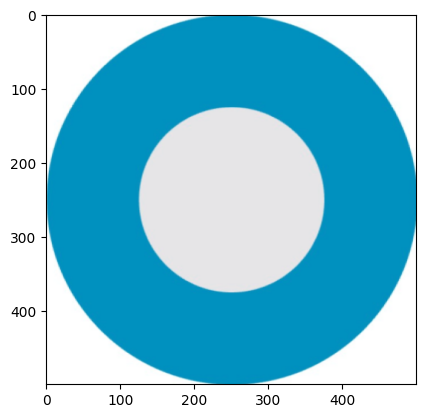

In [17]:
plt.imshow(ROI)

In [18]:
#se cambia el directorio de la carpeta de entrada de datos a la carpeta de salida 
os.chdir(ROI_Cropped_Outputpath)
#se genera la imagen resultado
cv.imwrite(img_list[x],ROI)

True

In [52]:
def Center_Crop(img):
    Input_img = Image.open(img)
    height,width = Input_img.size
    lum_img = Image.new('L',[height,width],0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(10,10), (490,490)], 0, 360, fill=255, outline='black')
    img_arr = np.array(Input_img)
    lum_img_arr = np.array(lum_img)
    final_img_arr = np.dstack((img_arr,lum_img_arr))
    matplotlib.image.imsave(img,final_img_arr)
    Input_img = Image.open(img)
    Input_img = Input_img.convert('RGB')
    reference1 = (20,20)
    color_reference = (0,0,0)
    bucket_img = ImageDraw.floodfill(Input_img, reference1, color_reference, thresh=50)
    Output_img = Input_img.save(img)
    print("Centro Recortado")
    

In [22]:
Output_img = Center_Crop(img_list[0])

Centro Recortado


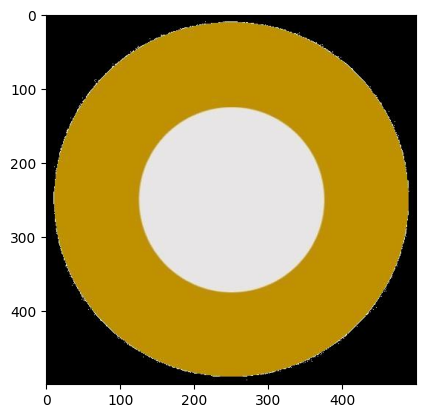

In [23]:
Output_img=cv.imread(img_list[0])
Output_img=cv.cvtColor(Output_img,cv.COLOR_BGR2RGB)
plt.imshow(Output_img)

In [57]:
def Image_segmentation(img):
    Input_img=cv.imread(img)
    Sample=Input_img[200:300,50:320]
    hsv_img=cv.cvtColor(Input_img,cv.COLOR_BGR2HSV)
    hsv2_img=Sample
    hsv2_img=cv.cvtColor(hsv2_img,cv.COLOR_BGR2HSV)
    h,s,v=cv.split(hsv2_img)
    ret_h, _= cv.threshold(h, 0,177, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_s, _= cv.threshold(s, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_v, _= cv.threshold(v, 0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)
    ret_h=int(ret_h)
    ret_s=int(ret_s)
    ret_v=int(ret_v)
    lower = np.array([ret_h,0,ret_v])
    upper = np.array([177,ret_v,255])
    mask=cv.inRange(hsv_img,lower,upper)
    Segmented_img=cv.bitwise_and(Input_img,Input_img,mask=mask)
    cv.imwrite(img,Segmented_img)
    print("Imagen segmentada")


In [27]:
Segmented_img = Image_segmentation(img_list[0])

Imagen segmentada


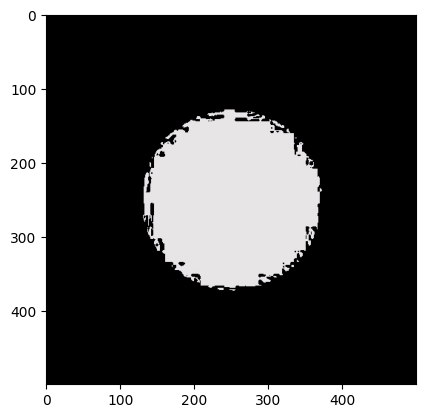

In [28]:
Segmented_img=cv.imread(img_list[0])
Segmented_img=cv.cvtColor(Segmented_img,cv.COLOR_BGR2RGB)
plt.imshow(Segmented_img)

In [60]:
def Image_reconstruction(img):
    ROI=cv.imread(img)
    ROI=cv.cvtColor(ROI,cv.COLOR_BGR2RGB)
    attempts=20
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    reshape_ROI=np.float32(ROI.reshape(ROI.shape[0]*ROI.shape[1],3))
    ret,label,ROIcenter=cv.kmeans(reshape_ROI,n_K,None,criteria,attempts,cv.KMEANS_PP_CENTERS)
    _,counts =np.unique(label, return_counts=True)
    fin = ROIcenter[label.flatten()]
    final_image = fin.reshape((ROI.shape))
    final_image = cv.cvtColor(final_image, cv.COLOR_BGR2RGB)
    HEXcolors = [0]
    Frequency =[0]
    R_array = [0]
    G_array = [0]
    B_array = [0]
    z=0
    y=0
    ROIcenter=np.uint8(ROIcenter)
    for y in range(n_K):
        HEXcolors.append(rgb_to_hex(ROIcenter[y]))
        Frequency.append(counts[y])
        R_array.append(ROIcenter[y,z])
        G_array.append(ROIcenter[y,z+1])
        B_array.append(ROIcenter[y,z+2])
    result_table = pd.DataFrame({'HEXcolors':HEXcolors,'Frequency':Frequency,'R':R_array,'G':G_array,'B':B_array})
    result_table = result_table.iloc[1: , :]
    return result_table

In [31]:
Image_reconstruction(img_list[0])

,HEXcolors,Frequency,R,G,B
1,#000000,206638,0,0,0
2,#e7e5e6,43362,231,229,230


In [53]:
os.chdir(Inputpath)

In [61]:
img_list[0]
ROI=Crop_plate(img_list[0])
#se cambia el directorio de la carpeta de entrada de datos a la carpeta de salida 
img_list[0]
os.chdir(ROI_Cropped_Outputpath)
#se genera la imagen resultado
cv.imwrite("C:\\Users\\luisd\\Documents\\GitHub\\image_kmeans_processing\\data\\processed\\ROI_Cropped\\"+img_list[0],ROI)
Center_Crop(img_list[0])
Image_segmentation(img_list[0])
df=Image_reconstruction(img_list[0])

ROI Localizada
Centro Recortado
Imagen segmentada


In [64]:
df=pd.DataFrame()

In [68]:
df=pd.DataFrame()
for img in img_list:
    os.chdir(Inputpath)
    ROI=Crop_plate(img)
    os.chdir(ROI_Cropped_Outputpath)
    #se genera la imagen resultado
    cv.imwrite("C:\\Users\\luisd\\Documents\\GitHub\\image_kmeans_processing\\data\\processed\\ROI_Cropped\\"+img,ROI)
    Center_Crop(img)
    Image_segmentation(img)
    df=pd.concat([df,Image_reconstruction(img)], ignore_index=True)
    

ROI Localizada
Centro Recortado
Imagen segmentada
ROI Localizada
Centro Recortado
Imagen segmentada


In [ ]:
# Append the new row to the DataFrame
df = df.append(new_row, ignore_index=True)

In [ ]:
# Concatenate the DataFrames
df = pd.concat([df, new_df], ignore_index=True

In [56]:
os.getcwd()

'C:\\Users\\luisd\\Documents\\GitHub\\image_kmeans_processing\\data\\processed\\ROI_Cropped'